In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

In [2]:
dataset_url = "WasteImagesDataset"
data_dir = pathlib.Path(dataset_url)

In [3]:
print(data_dir)

WasteImagesDataset


WasteImagesDataset\Aluminium\alum (115).jpg


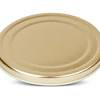

In [4]:
electronic = list(data_dir.glob('Aluminium/*'))
print(electronic[18])
PIL.Image.open(str(electronic[18]))

In [5]:
img_height, img_width = 224, 224
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5078 files belonging to 9 classes.
Using 4063 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5078 files belonging to 9 classes.
Using 1015 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


In [45]:
vgg_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(
    include_top = False,
    input_shape = (224, 224, 3),
    pooling = 'avg',
    classes = 9,
    weights = 'imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dense(9, activation = 'softmax'))

In [46]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 14,981,961
Trainable params: 267,273
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
epochs = 15
history = vgg_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/15
127/127 [==============================] - 55s 424ms/step - loss: 1.2251 - accuracy: 0.7347 - val_loss: 0.8119 - val_accuracy: 0.7626
Epoch 2/15
127/127 [==============================] - 39s 306ms/step - loss: 0.3441 - accuracy: 0.8883 - val_loss: 0.6510 - val_accuracy: 0.8236
Epoch 3/15
127/127 [==============================] - 39s 303ms/step - loss: 0.1287 - accuracy: 0.9559 - val_loss: 0.5686 - val_accuracy: 0.8552
Epoch 4/15
127/127 [==============================] - 39s 306ms/step - loss: 0.0590 - accuracy: 0.9833 - val_loss: 0.5875 - val_accuracy: 0.8562
Epoch 5/15
127/127 [==============================] - 39s 304ms/step - loss: 0.0285 - accuracy: 0.9943 - val_loss: 0.5830 - val_accuracy: 0.8601
Epoch 6/15
127/127 [==============================] - 39s 303ms/step - loss: 0.0174 - accuracy: 0.9980 - val_loss: 0.5757 - val_accuracy: 0.8611
Epoch 7/15
127/127 [==============================] - 39s 304ms/step - loss: 0.0131 - accuracy: 0.9993 - val_loss: 0.6035 - val_ac

In [50]:
import h5py

vgg_model.save('vgg16_history.h5')

with h5py.File('vgg16_history.h5', 'a') as hf:
    for key in history.history.keys():
        hf.create_dataset(key, data=history.history[key])

In [14]:
from tensorflow.keras.models import load_model
resnet_model_n = load_model('vgg16_history.h5')

1/1 [==============================] - 0s 22ms/step


<Figure size 1000x1000 with 0 Axes>

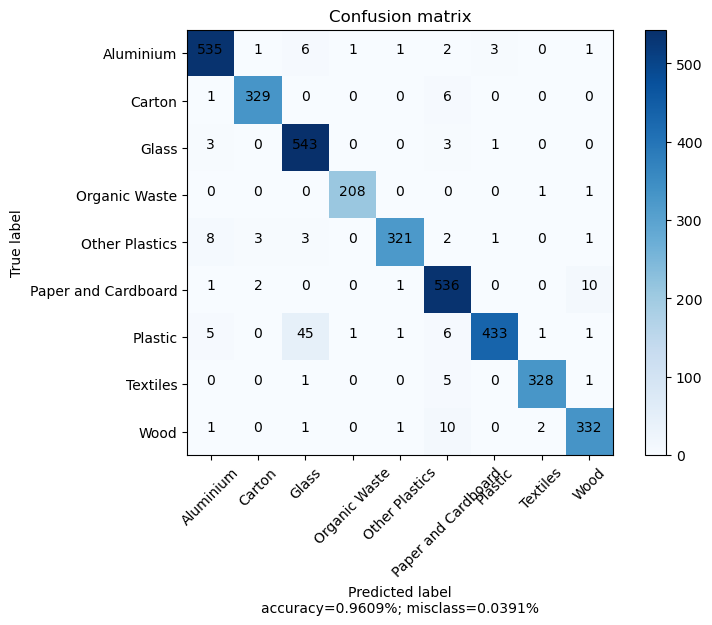

In [15]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "WasteImagesDataset/"
for i in os.listdir(path):
    folderPath = os.path.join(path, i)
    if os.path.isdir(folderPath):  # Check if it's a directory
        for j in os.listdir(folderPath)[:550]:
            fullPath = os.path.join(folderPath, j)
            try:
                  img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(224, 224))
                  img_array = tf.keras.preprocessing.image.img_to_array(img)
                  img_array = tf.expand_dims(img_array, 0) 
                
                  preds = resnet_model_n.predict(img_array)
                  true.append(class_names.index(i))
                  predictions.append(np.argmax(preds))
            except Exception as e:
                print(f'Error: {e}')

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), class_names )